In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the dataset

In [19]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/EMR (1)/Patient_info_cleaned.csv')
df.head(10)

,LOG_ID,MRN,DISCH_DISP_C,DISCH_DISP,LOS,ICU_ADMIN_FLAG,SURGERY_DATE,BIRTH_DATE,WEIGHT,SEX,...,PRIMARY_PROCEDURE_NM,PATIENT_CLASS_NM_ENCODED,PATIENT_CLASS_GROUP_ENCODED,OR_LOS_HOURS,AN_LOS_HOURS,HEIGHT_METRES,PRIMARY_PROCEDURE_NM_ENCODED,PRIMARY_ANES_TYPE_NM_ENCODED,AGE_GROUP,LOS_BINNED
0,cd1636c6279d73a0,2e92522a5f2a2a22,15.0,Home Routine,1.0,0,2018-12-20,47,2832.47,0,...,"INSERTION, PUBOVAGINAL SLING, WITH CYSTOSCOPY",1,1,4.97,4.97,1.68,"[101, 23851, 1010, 9047, 7103, 24965, 27076, 1...",2,47-57,0
1,fc53c06ee2cfe438,b7a91e623d957d8f,16.0,Hospice Facility,21.0,1,2019-09-27,81,2515.01,1,...,GI EGD DILATION,1,1,1.58,1.58,1.68,"[101, 21025, 1041, 2290, 2094, 29454, 3370, 102]",2,77-87,4
2,2f0090c47da34608,b68d6c7198f30f73,15.0,Home Routine,3.0,1,2019-04-08,49,1964.74,0,...,CRANIECTOMY,0,0,4.08,4.08,1.68,"[101, 13675, 7088, 22471, 16940, 102]",2,47-57,2
3,6d3b621880c6ced4,46aa48e89b9c50e8,15.0,Home Routine,1.0,0,2018-12-03,54,2638.47,0,...,"REVISION, RECONSTRUCTION, BREAST",1,1,3.67,3.67,1.60,"[101, 13921, 1010, 8735, 1010, 7388, 102]",2,47-57,0
4,82f89e10f2855420,c2756216cc89b795,15.0,Home Routine,1.0,0,2019-04-19,44,1880.08,0,...,"REVISION, RECONSTRUCTION, BREAST",1,1,6.63,6.63,1.68,"[101, 13921, 1010, 8735, 1010, 7388, 102]",2,37-47,0
5,8778901eeb9b6166,2e34dcb0791b8c0d,15.0,Home Routine,1.0,0,2020-03-17,59,2640.00,0,...,EGD (ESOPHAGOGASTRODUODENOSCOPY),1,1,2.02,2.02,1.68,"[101, 1041, 2290, 2094, 1006, 9686, 7361, 3270...",2,57-67,0
6,d56378d6b879a646,1e3abeb304c6dfbc,15.0,Home Routine,0.0,0,2019-11-20,56,3026.47,0,...,"INJECTION, FAT GRAFT",1,1,2.90,2.90,1.63,"[101, 13341, 1010, 6638, 22160, 2102, 102]",2,47-57,0
7,91b48ef5ac2bb217,46c1f8933170ca25,15.0,Home Routine,1.0,0,2019-03-01,32,2927.71,0,...,"MYOMECTOMY, UTERUS, ROBOT-ASSISTED, LAPAROSCOPIC",1,1,6.07,6.07,1.68,"[101, 2026, 8462, 6593, 16940, 1010, 21183, 21...",2,27-37,0
8,1906cc82ba498914,ec65fcf9422707a0,15.0,Home Routine,0.0,0,2019-06-23,57,2169.33,0,...,"HYSTEROSCOPY, WITH BIOPSY OR POLYPECTOMY",1,1,1.12,1.12,1.68,"[101, 1044, 27268, 27360, 3597, 7685, 1010, 20...",2,57-67,0
9,a724284bc59fe51a,bfec22a4fe8ece9f,15.0,Home Routine,0.0,0,2019-01-15,60,3128.77,0,...,"REVISION, RECONSTRUCTION, BREAST",1,1,6.62,6.62,1.68,"[101, 13921, 1010, 8735, 1010, 7388, 102]",2,57-67,0


##Q1: Factors that impact the length of hospitalization of a patient

Fitting 3 folds for each of 36 candidates, totalling 108 fits
AUC-ROC: 0.9453217723363416
Precision-Recall AUC (Macro-average): 0.8300859498661566


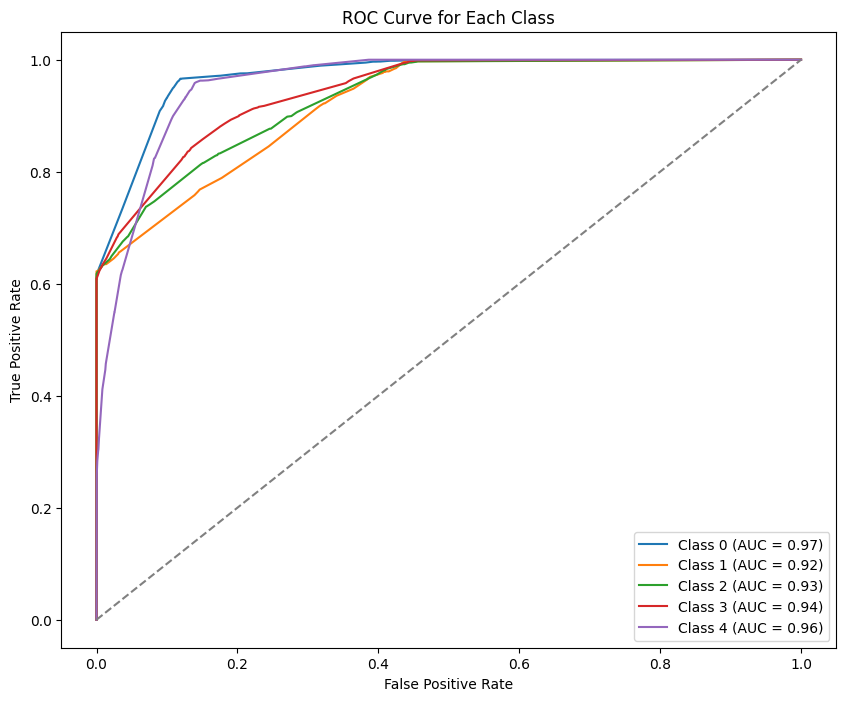

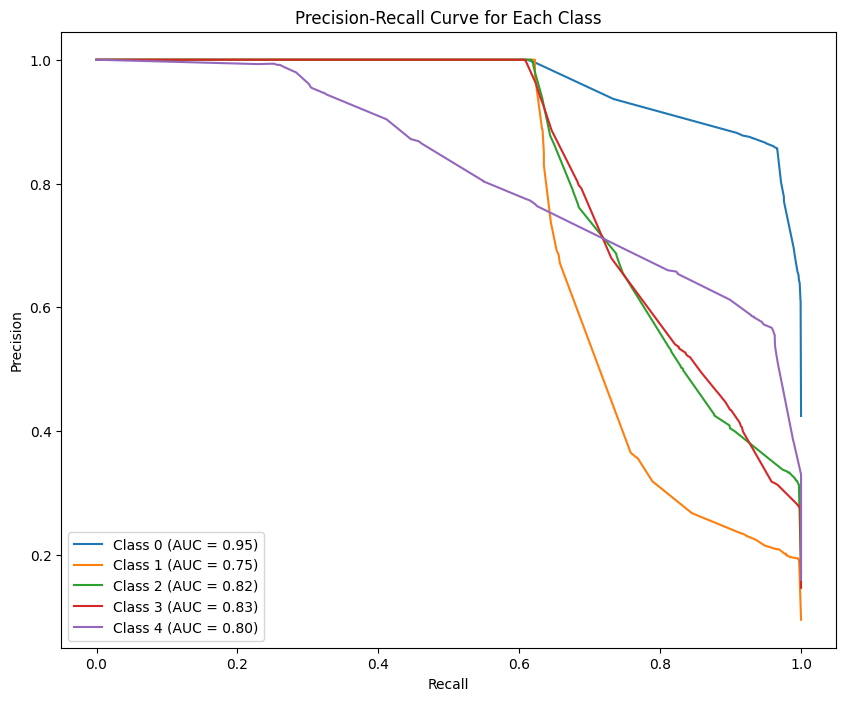

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve


# Bin for 'AN_LOS_HOURS' and 'LOS'
bin_edges = [0, 5, 10, 15, 20, 25, 30]
bin_labels = [1, 2, 3, 4, 5, 6]

# Binning
df['AN_LOS_HOURS_BINNED'] = pd.cut(df['AN_LOS_HOURS'], bins=bin_edges, labels=bin_labels)
df['LOS_BINNED'] = pd.qcut(df['LOS'], q=6, duplicates='drop')
df.dropna(subset=['LOS_BINNED'], inplace=True)

# categorical columns to numeric
df['LOS_BINNED'] = df['LOS_BINNED'].cat.codes

# Separate features and target
X = df[['BIRTH_DATE', 'AN_LOS_HOURS_BINNED', 'ICU_ADMIN_FLAG']]
y = df['LOS_BINNED'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['BIRTH_DATE']
categorical_features = ['AN_LOS_HOURS_BINNED', 'ICU_ADMIN_FLAG']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

# Decision Tree model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)

# Train
grid_search.fit(X_train, y_train)

# Predict
y_proba = grid_search.predict_proba(X_test)

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

# Precision-Recall
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

pr_auc = average_precision_score(y_test_bin, y_proba, average='macro')
print(f'Precision-Recall AUC (Macro-average): {pr_auc}')

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
n_classes = len(lb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_score(y_test_bin[:, i], y_proba[:, i]):.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AUC = {average_precision_score(y_test_bin[:, i], y_proba[:, i]):.2f})')

plt.title('Precision-Recall Curve for Each Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()


In [24]:

y_pred = grid_search.predict(X_test)

# results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Best hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy: 0.818378471921779
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4907
           1       1.00      0.62      0.77      1104
           2       1.00      0.62      0.76      1997
           3       0.92      0.63      0.75      1700
           4       0.59      0.93      0.72      1849

    accuracy                           0.82     11557
   macro avg       0.87      0.75      0.78     11557
weighted avg       0.86      0.82      0.82     11557



##Q2: Factors that Impact the ASA Rating of a Patient

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Accuracy: 0.926060606060606
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       603
           1       0.95      0.93      0.94      3683
           2       0.98      0.92      0.95      5842
           3       0.85      0.94      0.89      1274
           4       0.42      0.90      0.57       148

    accuracy                           0.93     11550
   macro avg       0.79      0.92      0.84     11550
weighted avg       0.94      0.93      0.93     11550



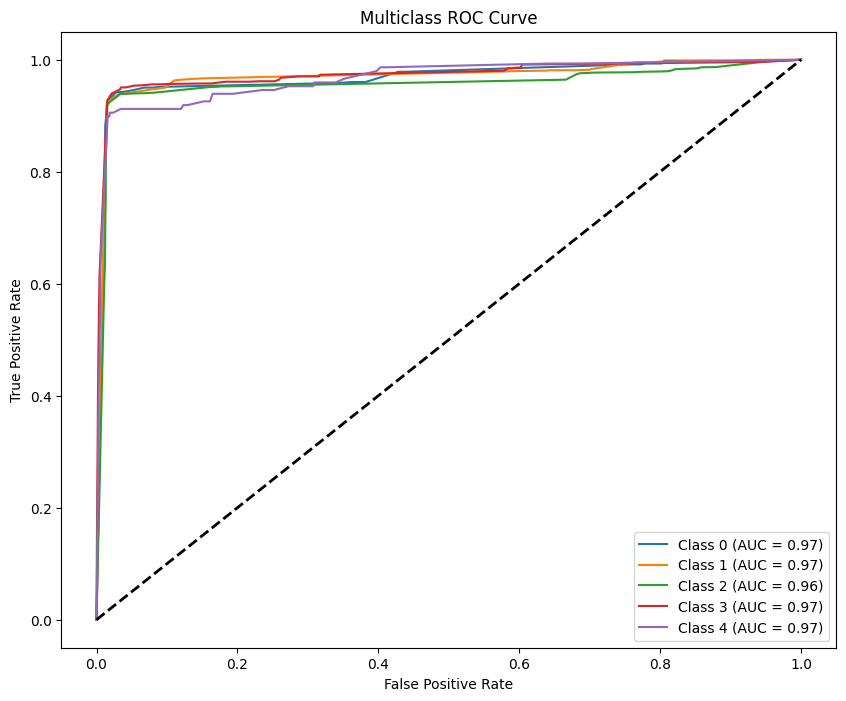

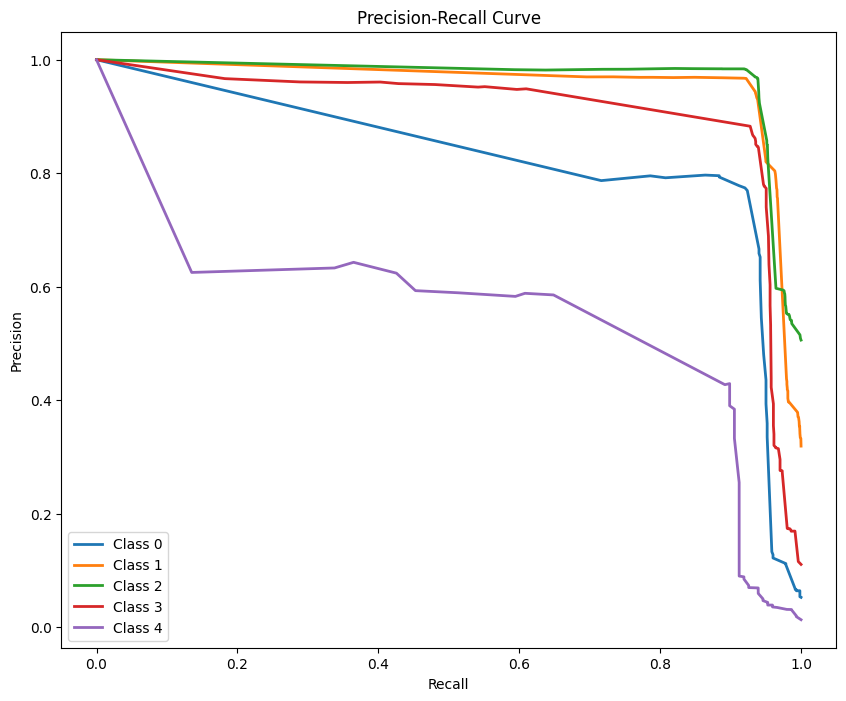

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np

df = df.dropna(subset=['ASA_RATING_C', 'BIRTH_DATE', 'LOS', 'Disease'])

min_age = df['BIRTH_DATE'].min()
max_age = df['BIRTH_DATE'].max()
age_bin_edges = list(range(int(min_age), int(max_age) + 10, 10))
age_bin_labels = [f"{i}-{i + 10}" for i in age_bin_edges[:-1]]
df['AGE_GROUP'] = pd.cut(df['BIRTH_DATE'], bins=age_bin_edges, labels=age_bin_labels, right=False)
df['LOS_BINNED'] = pd.qcut(df['LOS'], q=6, duplicates='drop').cat.codes

# Convert to categorical
df['ASA_RATING_C'] = df['ASA_RATING_C'].astype('category')
df = df[df['ASA_RATING_C'] != 5]
df['ASA_RATING_C'] = df['ASA_RATING_C'].cat.codes

X = df[['AGE_GROUP', 'LOS_BINNED', 'Disease']]
y = df['ASA_RATING_C']  # Target var

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_features = ['AGE_GROUP', 'Disease']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)])

# Model pipeline with class imbalance handling
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Prediction and evaluation
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Binarize output for ROC and AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_bin = np.array(grid_search.predict_proba(X_test))

# ROC Curve for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision vs Recall Curve for each class (excluding original class 5)
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Check if ASA_RATING_C, BIRTH_DATE, or Diseases have NaNs
df = df.dropna(subset=['ASA_RATING_C', 'BIRTH_DATE', 'LOS', 'Disease'])
min_age = df['BIRTH_DATE'].min()
max_age = df['BIRTH_DATE'].max()

age_bin_edges = list(range(int(min_age), int(max_age) + 10, 10))
age_bin_labels = [f"{i}-{i + 10}" for i in age_bin_edges[:-1]]

df['AGE_GROUP'] = pd.cut(df['BIRTH_DATE'], bins=age_bin_edges, labels=age_bin_labels, right=False)
df['LOS_BINNED'] = pd.qcut(df['LOS'], q=6, duplicates='drop')

df['LOS_BINNED'] = df['LOS_BINNED'].cat.codes
df['ASA_RATING_C'] = df['ASA_RATING_C'].astype('category')
df['ASA_RATING_C'] = df['ASA_RATING_C'].cat.codes

X = df[['AGE_GROUP', 'LOS_BINNED', 'Disease']]
y = df['ASA_RATING_C']  # Target variable

print(y.isnull().sum())

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_features = ['AGE_GROUP', 'Disease']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Random Forest model with handling for class imbalance
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)

# Train
grid_search.fit(X_train, y_train)

# Predict and eval
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# results
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


0
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Accuracy: 0.9195292896080298
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.83       618
           1       0.96      0.92      0.94      3722
           2       0.98      0.92      0.95      5770
           3       0.88      0.92      0.90      1320
           4       0.38      0.93      0.54       119
           5       0.04      1.00      0.09         8

    accuracy                           0.92     11557
   macro avg       0.67      0.93      0.71     11557
weighted avg       0.94      0.92      0.93     11557

